In [1]:
# --- NO TYPE 3 FONTS IN PDF OUTPUT ---
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.family"] = "DejaVu Sans"
mpl.rcParams["mathtext.fontset"] = "dejavusans"
mpl.rcParams["text.usetex"] = False

# Font sizes
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 12
# -------------------------------------

import os
import h5py
import yaml
import pickle
import shapely
import numpy as np
from utils import LatLonStandardScaler, StandardScaler

from sgptools.kernels import *
from sgptools.utils.gpflow import *
from sgptools.utils.metrics import *

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

2026-01-08 22:29:30.135911: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 22:29:30.209127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767932970.254839   56805 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767932970.267263   56805 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767932970.326633   56805 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
mission_log = "../launch/data/Coverage-mission-2026-01-08-23-59-54"
num_samples = 5000

# data file
fname = os.path.join(mission_log,
                     "mission-log.hdf5")

# load data
with h5py.File(fname, "r") as f:
    print(f.keys())
    fence_vertices = f["fence_vertices"][:].astype(float)
    X = f["X"][:].astype(float)
    y = f["y"][:].astype(float)

    X_objective = f["X_objective"][:].astype(float)

    X_init = f["X_init"][:].astype(float)
    y_init = f["y_init"][:].astype(float)

    for key in f.keys():
        if 'initial' in key:
            initial_path = f[key][:].astype(float)
        elif 'coverage' in key:
            sol_path = f[key][:].astype(float)

print(f'Mission Log: {mission_log}')
print(f'Number of data samples: {X.shape[0]}')
print(f'Number of reconstruction samples: {num_samples}')

<KeysViewHDF5 ['X', 'X_init', 'X_objective', 'coverage_path-00-04-16', 'fence_vertices', 'initial_path-23-59-54', 'y', 'y_init']>
Mission Log: ../launch/data/Coverage-mission-2026-01-08-23-59-54
Number of data samples: 2999
Number of reconstruction samples: 5000


In [3]:
X_candidates = X_objective
X_scaler = LatLonStandardScaler()
X_scaler.fit(X_candidates)
X_candidates = X_scaler.transform(X_candidates)
y_scaler = StandardScaler()
y_scaler.fit(y)

y = y_scaler.transform(y)
X = X_scaler.transform(X)

y_init = y_scaler.transform(y_init)
X_init = X_scaler.transform(X_init)

initial_path = X_scaler.transform(initial_path)
sol_path = X_scaler.transform(sol_path)

fence_vertices = X_scaler.transform(fence_vertices)

In [4]:
# Compute grid
distance = 0.3
len_x = max(X_candidates[:, 0])-min(X_candidates[:, 0])
len_y = max(X_candidates[:, 1])-min(X_candidates[:, 1])
num_x = int(np.ceil(len_x/distance))
num_y = int(np.ceil(len_y/distance))
extent = [min(X_candidates[:, 0]), max(X_candidates[:, 0]), 
          min(X_candidates[:, 1]), max(X_candidates[:, 1])]
grid_x, grid_y = np.mgrid[extent[0]:extent[1]:complex(num_x), 
                          extent[2]:extent[3]:complex(num_y)]
X_grid = np.stack([grid_x, grid_y], axis=-1)
X_grid = X_grid.reshape(-1, 2).astype(X_candidates.dtype)

print(num_x, num_y)

# Remove sensing locations outside the boundaries
pbounds = shapely.geometry.Polygon(fence_vertices)
points = shapely.points(X_grid)
inside_idx = shapely.contains(pbounds, points)
outside_idx = np.logical_not(inside_idx)

136 90


In [5]:
# Extract hyperparameters details from config.yaml
config_fname = os.path.join(mission_log, f"config.yaml")
with open(config_fname, 'r') as file:
    config = yaml.safe_load(file)
hyperparameter_config = config.get('hyperparameters', {})
kernel = hyperparameter_config.get('kernel_function', 'RBF')

# Use float32 and higher jitter for deep learning model based kernel functions
if kernel in ['Attentive', 'NeuralSpectral']:
    gpflow.config.set_default_float(np.float32)
    gpflow.config.set_default_jitter(1e-1)
else:
    gpflow.config.set_default_float(np.float64)
    gpflow.config.set_default_jitter(1e-6)

kernel_kwargs = hyperparameter_config.get('kernel', {})
kernel = get_kernel(kernel)(**kernel_kwargs)
noise_variance = float(hyperparameter_config.get('noise_variance', 1e-4))
optimizer_kwargs = config.get('optimizer', {})

2026-01-08 22:29:47.915274: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Max Variance: 1.5426489


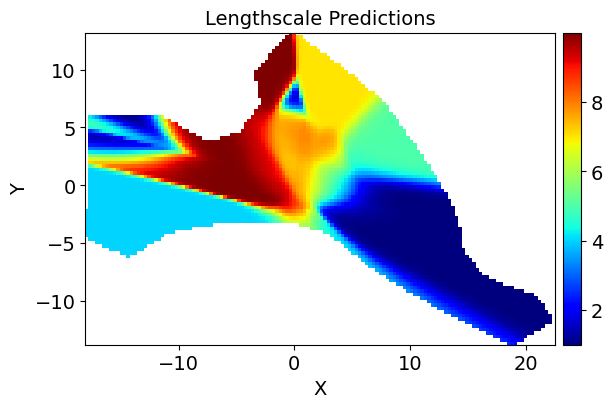

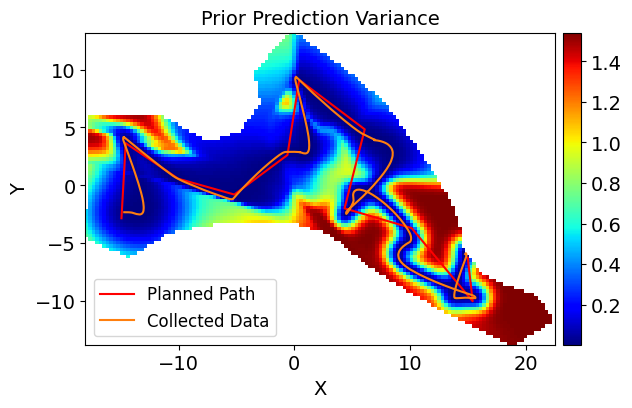

In [6]:
# Init GP model
_, _, _, gpr = get_model_params(np.vstack([X_init]).astype(np.float32), 
                                np.vstack([y_init]).astype(np.float32), 
                                kernel=kernel,
                                noise_variance=noise_variance,
                                return_model=True,
                                force_gp=True,
                                verbose=False,
                                max_steps=0)

# Load pre-trained parameters
fname = os.path.join(mission_log, f"model_params.pkl")
with open(fname, 'rb') as handle:
    params = pickle.load(handle)
gpflow.utilities.multiple_assign(gpr.kernel, params['kernel'])
gpflow.utilities.multiple_assign(gpr.likelihood, params['likelihood'])

mean, var = gpr.predict_f(X_candidates.astype(np.float32))
print("Max Variance:", var.numpy().max())

# ---- Plot lengthscale map ----
fig, ax = plt.subplots()

lengthscales = kernel.get_lengthscales(X_grid.astype(np.float32))
lengthscales[outside_idx] = np.nan

im = ax.imshow(
    lengthscales.reshape(num_x, num_y).T,
    origin='lower', cmap='jet',
    extent=extent
)
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.08)  # tweak size/pad as desired
fig.colorbar(im, cax=cax)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Lengthscale Predictions')

plt.show()


# ---- Plot variance map (prior) ----
fig, ax = plt.subplots()

mean, var = gpr.predict_f(X_grid.astype(np.float32))
mean = mean.numpy()
var = var.numpy()

var[outside_idx] = np.nan

im = ax.imshow(
    var.reshape(num_x, num_y).T,
    origin='lower', cmap='jet',
    extent=extent
)
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.08)  # tweak size/pad as desired
fig.colorbar(im, cax=cax)

ax.plot(initial_path[:, 0], initial_path[:, 1], c='r', label='Planned Path')
ax.plot(X_init[:, 0], X_init[:, 1], c='C1', label='Collected Data')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc='lower left')
ax.set_title('Prior Prediction Variance')

plt.show()


In [7]:
# Init GP model
_, _, _, gpr_post = get_model_params(np.vstack([X_init, X]).astype(np.float32), 
                                     np.vstack([y_init, y]).astype(np.float32), 
                                     kernel=kernel,
                                     noise_variance=noise_variance,
                                     return_model=True,
                                     force_gp=True,
                                     verbose=False,
                                     max_steps=0)

# Load pre-trained parameters
fname = os.path.join(mission_log, f"model_params.pkl")
with open(fname, 'rb') as handle:
    params = pickle.load(handle)
gpflow.utilities.multiple_assign(gpr_post.kernel, params['kernel'])
gpflow.utilities.multiple_assign(gpr_post.likelihood, params['likelihood'])

mean, var = gpr_post.predict_f(X_candidates.astype(np.float32))
print("Max Variance:", var.numpy().max())

Max Variance: 0.60182184


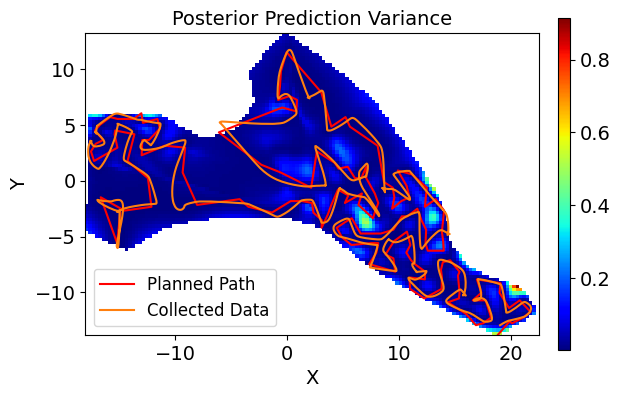

In [8]:
# ---- Plot variance map (posterior) ----

mean, var = gpr_post.predict_f(X_grid.astype(np.float32))
mean = mean.numpy()
var = var.numpy()
var[outside_idx] = np.nan

fig, ax = plt.subplots()

cmap_im = ax.imshow(
    var.reshape(num_x, num_y).T,
    origin='lower', cmap='jet',
    extent=extent
)
ax.set_aspect('equal')
cbar = fig.colorbar(cmap_im, ax=ax, fraction=0.046, pad=0.04, shrink=0.9, aspect=30)

ax.plot(sol_path[:, 0], sol_path[:, 1], c='r', label='Planned Path')
ax.plot(X[:, 0], X[:, 1], c='C1', label='Collected Data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc='lower left')
ax.set_title('Posterior Prediction Variance')

plt.show()
